In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [3]:
X=np.load('data_X_with_callback.npy')
y=np.load('data_y_with_callback.npy')

In [4]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [6]:
from keras import models, layers
from keras import Input
from keras.applications import ResNet50
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

input = Input(shape=(224, 224, 3))
model = ResNet50(input_tensor=input, include_top=False, weights=None)
model.trainable = False
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
for layer in model.layers:
    layer.trainable=False
    
x = model.output
x=layers.Flatten()(x)
x = Dense(1024, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(4, activation='softmax')(x)
additional_model=Model(inputs=model.input, outputs=output)

additional_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [8]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [8]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='ResNet_fine tuning.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [9]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
class_weight = {0: 0.8,
                1: 1,
                2: 1,
                3: 1}

In [11]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=3, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/3
54/53 [==============================] - 20s 369ms/step - loss: 1.3028 - acc: 0.3636 - auc: 0.5901 - precision: 0.4176 - recall: 0.1221 - f1score: 0.1096 - val_loss: 180.2766 - val_acc: 0.2238 - val_auc: 0.5990 - val_precision: 0.3828 - val_recall: 0.1126 - val_f1score: nan
Epoch 2/3
54/53 [==============================] - 13s 250ms/step - loss: 1.1953 - acc: 0.4324 - auc: 0.6018 - precision: 0.3691 - recall: 0.1141 - f1score: 0.1157 - val_loss: 282.6840 - val_acc: 0.3380 - val_auc: 0.6148 - val_precision: 0.3958 - val_recall: 0.1287 - val_f1score: nan
Epoch 3/3
54/53 [==============================] - 15s 280ms/step - loss: 1.1728 - acc: 0.4307 - auc: 0.6212 - precision: 0.4044 - recall: 0.1329 - f1score: 0.1176 - val_loss: 258.3891 - val_acc: 0.2681 - val_auc: 0.6224 - val_precision: 0.4022 - val_recall: 0.1336 - val_f1score: nan


In [ ]:
len(additional_model.layers)

In [12]:
for layer in additional_model.layers[:46]:
    layer.trainable=False

for layer in additional_model.layers[46:]:
    layer.trainable=True

In [13]:
for layer in additional_model.layers:
    print(layer, layer.trainable)
    
additional_model.summary()

<keras.engine.input_layer.InputLayer object at 0x00000273A6A2C848> False
<keras.layers.convolutional.ZeroPadding2D object at 0x00000273A6A2C148> False
<keras.layers.convolutional.Conv2D object at 0x00000273A6A21748> False
<keras.layers.normalization.BatchNormalization object at 0x000002723D974588> False
<keras.layers.core.Activation object at 0x000002723D974308> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000002723D9A2D88> False
<keras.layers.pooling.MaxPooling2D object at 0x0000027243D5AD08> False
<keras.layers.convolutional.Conv2D object at 0x0000027243D7B4C8> False
<keras.layers.normalization.BatchNormalization object at 0x0000027243DAFA88> False
<keras.layers.core.Activation object at 0x0000027243DAF848> False
<keras.layers.convolutional.Conv2D object at 0x0000027243DB1A48> False
<keras.layers.normalization.BatchNormalization object at 0x0000027243F1D608> False
<keras.layers.core.Activation object at 0x0000027243F3ED08> False
<keras.layers.convolutional.Conv2D objec

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [14]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [15]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=10, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/10
54/53 [==============================] - 26s 473ms/step - loss: 1.1409 - acc: 0.4516 - auc_1: 0.7108 - precision_1: 0.6489 - recall_1: 0.1238 - f1score: 0.1199 - val_loss: 2.8366 - val_acc: 0.2517 - val_auc_1: 0.6873 - val_precision_1: 0.5207 - val_recall_1: 0.1319 - val_f1score: 0.0854
Epoch 2/10
54/53 [==============================] - 14s 261ms/step - loss: 1.0911 - acc: 0.4796 - auc_1: 0.6820 - precision_1: 0.4937 - recall_1: 0.1384 - f1score: 0.1246 - val_loss: 1.6298 - val_acc: 0.2634 - val_auc_1: 0.6886 - val_precision_1: 0.5114 - val_recall_1: 0.1423 - val_f1score: 0.0946
Epoch 3/10
54/53 [==============================] - 14s 267ms/step - loss: 1.0795 - acc: 0.4860 - auc_1: 0.6899 - precision_1: 0.5187 - recall_1: 0.1451 - f1score: 0.1267 - val_loss: 1.5564 - val_acc: 0.2284 - val_auc_1: 0.6928 - val_precision_1: 0.5289 - val_recall_1: 0.1463 - val_f1score: 0.0937
Epoch 4/10
54/53 [==============================] - 14s 267ms/step - loss: 1.0554 - acc: 0.4860 - auc_1

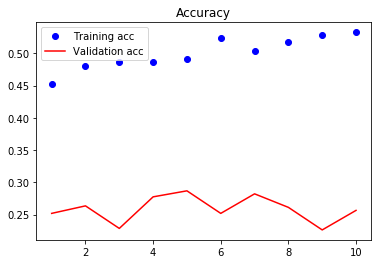

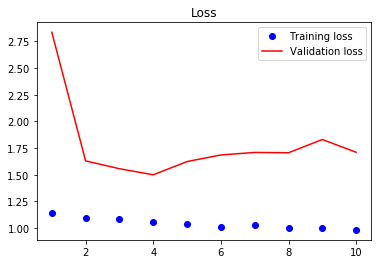

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [17]:
for layer in additional_model.layers:
    layer.trainable=True

In [18]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=37, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/37
54/53 [==============================] - 34s 621ms/step - loss: 0.9845 - acc: 0.5402 - auc: 0.7970 - precision_2: 0.6486 - recall_2: 0.3023 - f1score: 0.1395 - val_loss: 2.9203 - val_acc: 0.2051 - val_auc: 0.7457 - val_precision_2: 0.5555 - val_recall_2: 0.3013 - val_f1score: 0.0708
Epoch 2/37
54/53 [==============================] - 20s 370ms/step - loss: 0.9670 - acc: 0.5379 - auc: 0.7359 - precision_2: 0.5355 - recall_2: 0.2977 - f1score: 0.1398 - val_loss: 1.9677 - val_acc: 0.2145 - val_auc: 0.7348 - val_precision_2: 0.5335 - val_recall_2: 0.2933 - val_f1score: 0.0833
Epoch 3/37
54/53 [==============================] - 20s 374ms/step - loss: 0.9654 - acc: 0.5326 - auc: 0.7368 - precision_2: 0.5368 - recall_2: 0.2951 - f1score: 0.1407 - val_loss: 1.7123 - val_acc: 0.2145 - val_auc: 0.7379 - val_precision_2: 0.5449 - val_recall_2: 0.2915 - val_f1score: 0.0880
Epoch 4/37
54/53 [==============================] - 19s 357ms/step - loss: 0.9829 - acc: 0.5291 - auc: 0.7397 - pre

Epoch 29/37
54/53 [==============================] - 20s 364ms/step - loss: 0.9640 - acc: 0.5373 - auc: 0.7887 - precision_2: 0.6356 - recall_2: 0.3103 - f1score: 0.1413 - val_loss: 1.1588 - val_acc: 0.4848 - val_auc: 0.7889 - val_precision_2: 0.6359 - val_recall_2: 0.3105 - val_f1score: 0.1322
Epoch 30/37
54/53 [==============================] - 19s 361ms/step - loss: 0.9463 - acc: 0.5495 - auc: 0.7892 - precision_2: 0.6360 - recall_2: 0.3108 - f1score: 0.1432 - val_loss: 1.1943 - val_acc: 0.4872 - val_auc: 0.7895 - val_precision_2: 0.6366 - val_recall_2: 0.3113 - val_f1score: 0.1312
Epoch 31/37
54/53 [==============================] - 19s 361ms/step - loss: 0.9487 - acc: 0.5513 - auc: 0.7897 - precision_2: 0.6370 - recall_2: 0.3115 - f1score: 0.1426 - val_loss: 1.1853 - val_acc: 0.4895 - val_auc: 0.7900 - val_precision_2: 0.6377 - val_recall_2: 0.3119 - val_f1score: 0.1315
Epoch 32/37
54/53 [==============================] - 19s 361ms/step - loss: 0.9359 - acc: 0.5478 - auc: 0.7903 -

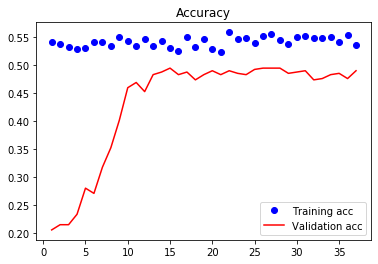

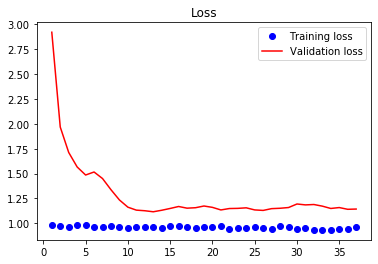

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [ ]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

In [9]:
import tensorflow as tf

new_model = models.load_model('ResNet_1.hdf5',compile=False)

new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node resnet50/conv1/convolution (defined at C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_23109]

Function call stack:
keras_scratch_graph


In [ ]:
X_test=np.load('X_val_with_callback.npy')
y_test=np.load('y_val_with_callback.npy')

In [ ]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))